In [22]:
import scipy.io
import pandas as pd
import numpy as np
import itertools
from ci_test import ci_test
import pickle
import cdt
import networkx as nx
import matplotlib.pyplot as plt

In [80]:
datasets = []

for dataset_i in range(1,5):
    d_mat = scipy.io.loadmat(f"D{dataset_i}.mat")
    datasets.append(np.array(pd.DataFrame(d_mat['D'])))

In [142]:
def pc1(dataset: np.ndarray) -> np.ndarray:
    n_columns = dataset.shape[1]
    all_nodes = range(n_columns)

    # Initialize a fully connected adjency matrix (no self connection since its a DAG)
    adjacency_matrix = np.ones((n_columns, n_columns)) - np.identity(n_columns)
    # Initialize a list of sets to keep for the edge orientation phase
    #Z_set = np.full((n_columns, n_columns), set())
    Z_set = [[set() for i in range(n_columns)] for j in range(n_columns)]
    # Pick the 1st variable
    for var_i in all_nodes:
        nodes = list(all_nodes)
        nodes.remove(var_i)
        # Pick a different 2nd variable
        for var2_i in nodes:
            # Pick a condition set
            for n_controls in all_nodes:
                possible_controls = list(all_nodes)
                possible_controls.remove(var_i)
                possible_controls.remove(var2_i)

                possible_controls = list(itertools.combinations(possible_controls, n_controls))

                for condition_set in possible_controls:
                    test = ci_test(dataset, var_i, var2_i, condition_set)

                    if test:
                        adjacency_matrix[var_i][var2_i] =  adjacency_matrix[var2_i][var_i] = 0

                        Z_set[var_i][var2_i] |= set(condition_set)
                        Z_set[var2_i][var_i] |= set(condition_set)

    return adjacency_matrix, Z_set





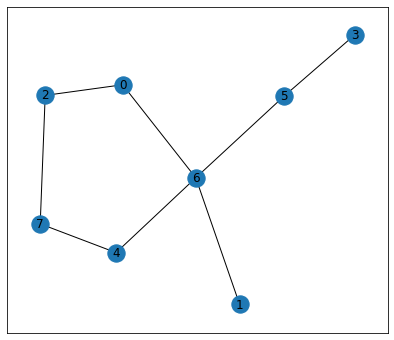

In [87]:
plt.figure(figsize = (15,6))
plt.subplot(121)
G2 = nx.from_numpy_matrix(pc1(datasets[1]))
nx.draw_networkx(G2, with_labels = True)

In [140]:
def add_v_structures(dataset: np.ndarray, graph: nx.Graph, Z_set: [set]) -> nx.DiGraph:
    directed_graph = nx.DiGraph(graph)
    nodes = graph.nodes

    for node_pair in itertools.combinations(nodes, 2):
        i = node_pair[0]
        j = node_pair[1]

        i_childs = set(directed_graph.successors(i))
        if j in i_childs:
            continue
        j_childs = set(directed_graph.successors(j))
        if i in j_childs:
            continue
        if Z_set[i][j] is None: # is none
            continue

        common_childs = i_childs & j_childs
        for children in common_childs:
            if children not in Z_set[i][j]:
                if directed_graph.has_edge(children, i):
                    directed_graph.remove_edge(children, i)
                if directed_graph.has_edge(children, j):
                    directed_graph.remove_edge(children, j)

    return directed_graph

In [143]:
adjacency_mat, condition_set = pc1(datasets[0])
graph = nx.from_numpy_matrix(adjacency_mat)
directed_graph = add_v_structures(datasets[0], graph, condition_set)

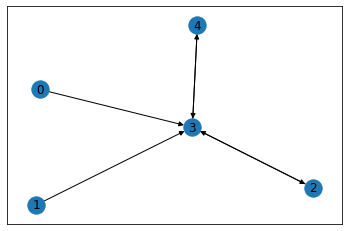

In [144]:
nx.draw_networkx(directed_graph, with_labels = True)

In [130]:
condition_set

[[set(),
  {2, 3, 4, 5, 6, 7},
  set(),
  {1, 2, 4, 5, 6, 7},
  {1, 2, 3, 5, 6, 7},
  {1, 2, 3, 4, 6, 7},
  set(),
  {1, 2, 3, 4, 5, 6}],
 [{2, 3, 4, 5, 6, 7},
  set(),
  {0, 3, 4, 5, 6, 7},
  {0, 2, 4, 5, 6, 7},
  {0, 2, 3, 5, 6, 7},
  {0, 2, 3, 4, 6, 7},
  set(),
  {0, 2, 3, 4, 5, 6}],
 [set(),
  {0, 3, 4, 5, 6, 7},
  set(),
  {0, 1, 4, 5, 6, 7},
  {0, 1, 3, 5, 6, 7},
  {0, 1, 3, 4, 6, 7},
  {1, 3, 4, 5, 7},
  set()],
 [{1, 2, 4, 5, 6, 7},
  {0, 2, 4, 5, 6, 7},
  {0, 1, 4, 5, 6, 7},
  set(),
  {0, 1, 2, 5, 6, 7},
  set(),
  {0, 1, 2, 4, 5, 7},
  {0, 1, 2, 4, 5, 6}],
 [{1, 2, 3, 5, 6, 7},
  {0, 2, 3, 5, 6, 7},
  {0, 1, 3, 5, 6, 7},
  {0, 1, 2, 5, 6, 7},
  set(),
  {2, 3, 7},
  set(),
  set()],
 [{1, 2, 3, 4, 6, 7},
  {0, 2, 3, 4, 6, 7},
  {0, 1, 3, 4, 6, 7},
  set(),
  {2, 3, 7},
  set(),
  set(),
  {0, 1, 2, 3, 4, 6}],
 [set(),
  set(),
  {1, 3, 4, 5, 7},
  {0, 1, 2, 4, 5, 7},
  set(),
  set(),
  set(),
  {0, 1, 2, 3, 4, 5}],
 [{1, 2, 3, 4, 5, 6},
  {0, 2, 3, 4, 5, 6},
  set(),
  {0,

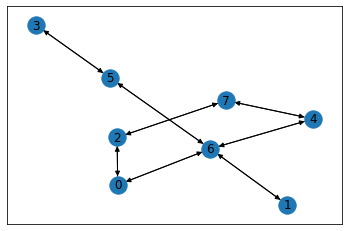

In [89]:
def direct_edges(dataset: np.ndarray, graph: nx.Graph) -> nx.DiGraph:




In [ ]:
graph = nx.from_numpy_matrix(pc1(datasets[1]))

directed_graph = add_v_structures(datasets[i], graph)
directed_graph = orient_meek2(datasets[i], orientmeek1(datasets[i], directed_graph)

[[set(), set(), set(), set(), set()],
 [set(), set(), set(), set(), set()],
 [set(), set(), set(), set(), set()],
 [set(), set(), set(), set(), set()],
 [set(), set(), set(), set(), set()]]